In [1]:
# Disable tensorflow spam (needs to happen before tensorflow gets imported)
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # set to "2" to see TensorRT errors
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))

import numpy as np
import tensorflow as tf
import cv2
from time import perf_counter
from trtutils import OptimizedModel
import system
import argparse
import pandas as pd

system.disable_preallocation()
# system.summary()


def log_result(data, filename="benchmark.csv"):
    """Append a dictionary of scalar keys as a row to a CSV file."""
    df = pd.DataFrame({k: [v] for k, v in data.items()})
    
    if os.path.exists(filename):
        df = pd.concat([
            pd.read_csv(filename),
            df,
        ])
    df.to_csv(filename, index=False)


def read_frames(video_path, fidxs=None, grayscale=True):
    """Read frames from a video file.
    
    Args:
        video_path: Path to MP4
        fidxs: List of frame indices or None to read all frames (default: None)
        grayscale: Keep only one channel of the images (default: True)
    
    Returns:
        Loaded images in array of shape (n_frames, height, width, channels) and dtype uint8.
    """
    vr = cv2.VideoCapture(video_path)
    if fidxs is None:
        fidxs = np.arange(vr.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []
    for fidx in fidxs:
        vr.set(cv2.CAP_PROP_POS_FRAMES, fidx)
        img = vr.read()[1]
        if grayscale:
            img = img[:, :, [0]]
        frames.append(img)
    return np.stack(frames, axis=0)

In [2]:
%%time
# opt_model_path, save_path = "data/inference_td_trt_FP16", "latency.inference_td_trt_FP16.csv"
# opt_model_path, save_path = "data/inference_td_trt_FP32", "latency.inference_td_trt_FP32.csv"
opt_model_path, save_path = "data/inference_td_trt_FP16", "latency.inference_td_id_trt_FP16.csv"
# opt_model_path, save_path = "data/inference_td_trt_FP16", "latency.inference_td_id_trt_FP32.csv"
test_data = "data/190719_090330_wt_18159206_rig1.2@15000-17560.mp4"
batch_sizes = [1, 16, 32]

reps = 5
N = 1280

imgs = read_frames(test_data, np.arange(N))
opt_model = OptimizedModel(saved_model_dir=opt_model_path)

res = None
for batch_size in batch_sizes:
    dts = []
    for rep in range(reps + 1):
        for i in range(0, N, batch_size):
            t0 = perf_counter()
            opt_model.predict(imgs[i:(i+batch_size)])
            dt = perf_counter() - t0
            if rep > 0:
                dts.append(dt)
    dts = np.array(dts)
    
    res_ = pd.DataFrame({"batch_size": np.full(dts.shape, batch_size), "dts": dts})
    if res is None:
        res = res_
    else:
        res = pd.concat([res, res_])

res["fps"] = res["batch_size"] / res["dts"]
res.to_csv(save_path, index=False)

CPU times: user 14min 44s, sys: 38.6 s, total: 15min 23s
Wall time: 6min 5s


In [3]:
res.groupby("batch_size").mean()

,dts,fps
batch_size,,
1,0.003355,298.309589
16,0.020792,769.689226
32,0.048715,681.332194


In [5]:
# Setup some plotting stuff
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = False
mpl.rcParams["font.size"] = 15
# mpl.rcParams["font.family"] = "sans-serif"
# mpl.rcParams["font.sans-serif"] = ["Arial"]
mpl.rcParams["axes.titlesize"] = "xx-large"  # medium, large, x-large, xx-large
mpl.style.use("seaborn-deep")

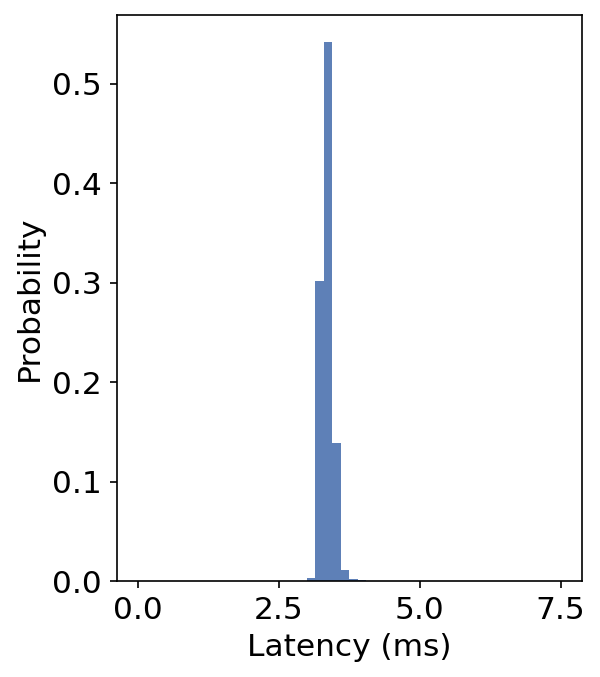

In [7]:
res["Latency (ms)"] = res["dts"] * 1000
    
plt.figure(figsize=(4, 5))
h = sns.histplot(x="Latency (ms)", data=res.query("batch_size == 1"), stat="probability", binrange=(0, 7.5), bins=50, linewidth=0, alpha=0.9)

In [11]:
# all_benchmarks = pd.read_csv("/home/talmo/gdrive/sleap-data/paper/all_benchmarks.csv")
all_benchmarks = pd.read_csv("all_benchmarks.csv")
all_benchmarks

,dataset,model,centroid_model,batch_size,gpu,cpu,platform,sleap,using_cpu_only,is_td_model,...,n_frames,img_height,img_width,img_channels,first_run,fps,fps_sd,latency,latency_sd,timestamp
0,flies13,sleap-data/datasets/wt_gold.13pt/models.tracki...,sleap-data/datasets/wt_gold.13pt/models.tracki...,32,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1024,1,10.417257,400.774457,1.850647,0.009845,0.000334,2021-05-12 21:00:30.080169
1,flies13,sleap-data/datasets/wt_gold.13pt/models.tracki...,sleap-data/datasets/wt_gold.13pt/models.tracki...,256,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1024,1,12.501030,412.963823,1.327336,0.009721,0.000381,2021-05-13 00:29:07.409299
2,flies13,sleap-data/datasets/wt_gold.13pt/models.tracki...,sleap-data/datasets/wt_gold.13pt/models.tracki...,4,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1024,1,13.085293,273.215999,1.096466,0.009720,0.000369,2021-05-13 00:35:55.584708
3,flies13,sleap-data/datasets/wt_gold.13pt/models.tracki...,sleap-data/datasets/wt_gold.13pt/models.tracki...,8,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1024,1,11.331011,335.735535,2.579341,0.009942,0.000323,2021-05-13 00:39:07.912693
4,flies13,sleap-data/datasets/wt_gold.13pt/models.tracki...,sleap-data/datasets/wt_gold.13pt/models.tracki...,16,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1024,1,10.937122,366.499807,1.200770,0.009997,0.000324,2021-05-13 00:42:17.769830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,bees,sleap-data/experiments/rf_expts/rf_expts.bees....,NaN,16,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,False,...,1280,1536,2048,1,66.478200,21.543861,0.088938,0.059140,0.001269,2021-05-19 17:58:09.453937
65,gerbils,sleap-data/datasets/nyu-gerbils/cohort1_compre...,sleap-data/datasets/nyu-gerbils/cohort1_compre...,32,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,2560,1024,1280,3,105.145953,73.111943,0.056685,0.025459,0.006103,2021-05-12 22:48:41.715795
66,gerbils,sleap-data/datasets/nyu-gerbils/cohort1_compre...,sleap-data/datasets/nyu-gerbils/cohort1_compre...,32,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,True,...,1280,1024,1280,3,69.077709,73.683588,0.091169,0.026101,0.018236,2021-05-13 15:31:54.173258
67,gerbils,sleap-data/datasets/nyu-gerbils/cohort1_compre...,NaN,32,GPU 0: NVIDIA TITAN RTX (UUID: GPU-1e8a80b8-8c...,Intel(R) Core(TM) i7-10700K CPU @ 3.80GHz,Windows-10-10.0.19041-SP0,1.1.1,False,False,...,2560,1024,1280,3,63.385451,43.996739,0.060927,0.028583,0.000644,2021-05-12 22:38:04.150804


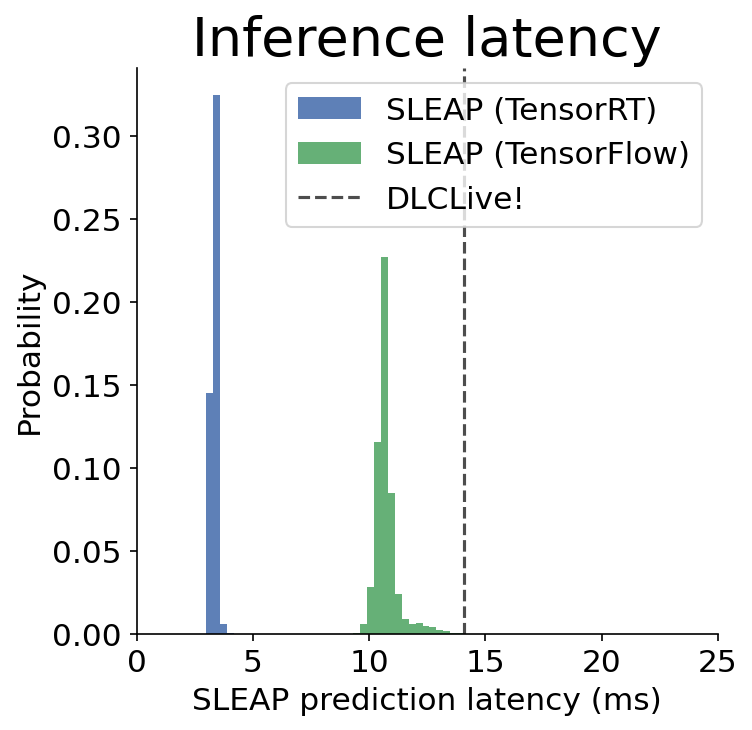

In [47]:
plt.figure(figsize=(5, 5))

res1 = pd.read_csv("speed.id_model_latency.flies13.csv")
res1["Engine"] = "SLEAP (TensorFlow)"
res2 = pd.read_csv("latency.inference_td_id_trt_FP16.csv")
res2["Latency (ms)"] = res2["dts"] * 1000
res2["Engine"] = "SLEAP (TensorRT)"
res = pd.concat([res2, res1])

h = sns.histplot(x="Latency (ms)", data=res, hue="Engine", stat="probability", binrange=(0, 15), bins=50, linewidth=0, alpha=0.9)

# https://deeplabcut.github.io/DLC-inferencespeed-benchmark/
hl = plt.axvline(1000/71, linestyle="--", c="0.3", label="DLCLive!")

plt.xlim([0, 25])
ax = plt.gca()
ax.legend(handles=ax.legend_.legendHandles + [hl], labels=["SLEAP (TensorRT)", "SLEAP (TensorFlow)", "DLCLive!"], title="", loc="upper right")

plt.xlabel("SLEAP prediction latency (ms)")
plt.title("Inference latency")
sns.despine()

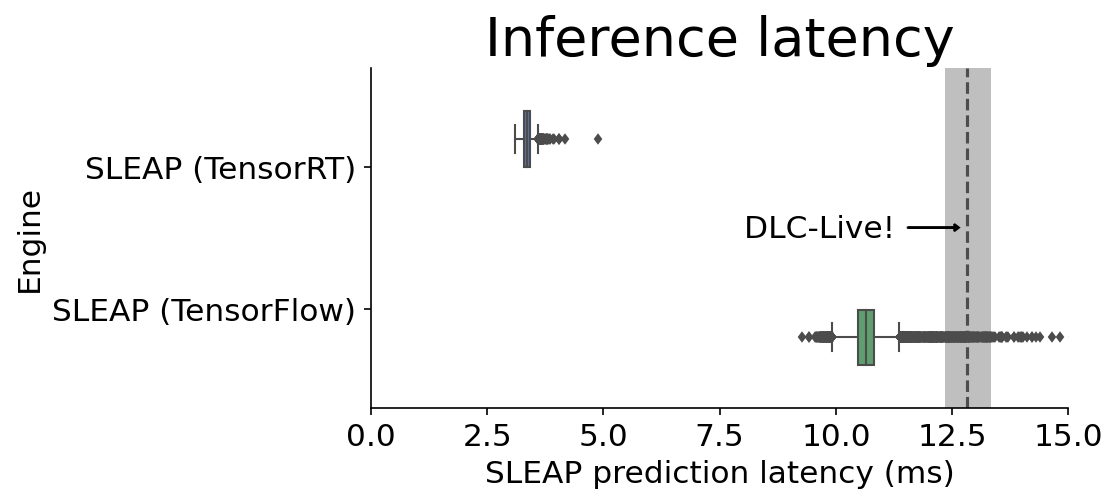

In [101]:
plt.figure(figsize=(6, 3))

res1 = pd.read_csv("speed.id_model_latency.flies13.csv")
res1["Engine"] = "SLEAP (TensorFlow)"
res2 = pd.read_csv("latency.inference_td_id_trt_FP16.csv")
res2 = res2.query("batch_size == 1")
res2["Latency (ms)"] = res2["dts"] * 1000
res2["Engine"] = "SLEAP (TensorRT)"
res = pd.concat([res2, res1])

h = sns.boxplot(x="Latency (ms)", y="Engine", data=res, hue="Engine", orient="h", linewidth=1, fliersize=3)

# https://deeplabcut.github.io/DLC-inferencespeed-benchmark/
# Mouse: 917 x 698, 8 keypoints, 1 animal
plt.axvspan(1000/(78-3), 1000/(78+3), fc="0.5", alpha=0.5)
plt.axvline(1000/78, linestyle="--", c="0.3")

plt.text(1000/(78+3), 0.5, "DLC-Live!     ", ha="right")
plt.arrow(x=1000/(78+3) - 0.8, y=0.425, dx=1, dy=0, head_width=0.05, head_length=0.1, fc="k", ec="k")

plt.xlim([0, 15])
plt.legend([],[], frameon=False)

plt.xlabel("SLEAP prediction latency (ms)")
plt.title("Inference latency")
sns.despine()

In [102]:
res.groupby("Engine").mean()

,batch_size,dts,fps,Latency (ms)
Engine,,,,
SLEAP (TensorFlow),NaN,NaN,NaN,10.726849
SLEAP (TensorRT),1.0,0.003355,298.309589,3.355100


In [106]:
1024 * 1024 * 1

1048576

In [105]:
(2 * 13 * (2 + 1 + 2)) * 4

520

In [107]:
520 / 1024

0.5078125

In [108]:
res2 = pd.read_csv("latency.inference_td_id_trt_FP16.csv")
res2.groupby("batch_size").mean()

,dts,fps
batch_size,,
1,0.003355,298.309589
16,0.020792,769.689226
32,0.048715,681.332194
